In [84]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import plotly_express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
import datetime
from lightgbm import LGBMRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.metrics import r2_score

In [85]:
conn = sql.connect('Data/db/btc.db')
cursor = conn.cursor()
df_1d = pd.read_sql_query("SELECT * FROM btc_1d", conn)


In [86]:
df_1d.drop(columns=['open', 'high', 'low', 'volume', 'var',
       'return', 'diff', 'volatility', 'rsi_14',
       'rsi_28', 'rsi_14_shifted', 'rsi_28_shifted', 'ma_5', 'ma_20', 'ma_100',
       'MiddleBand', 'UpperBand', 'LowerBand', 'K', 'D', 'close_shifted', 'TR',
       'ATR', 'TP', 'CCI', 'lag1_TR', 'lag2_TR', 'lag1_ATR', 'lag2_ATR'],inplace=True)

In [87]:
fecha = df_1d['date'][-1:].values[0]
ultima_fecha = pd.to_datetime(fecha)
# Número de días que quieres generar (ajusta este valor según tu necesidad)
num_dias = len(df_1d)

# Crear una lista de fechas decrementando un día en cada iteración
fechas = pd.date_range(end=ultima_fecha, periods=num_dias)

df_1d['date'] = fechas
df_1d.index = fechas

In [88]:
df_1d['mes'] = df_1d.index.month
data = pd.get_dummies(df_1d, columns=['reward', 'mes'], dtype=int)

In [89]:
last_date = df_1d['date'][-1:].values[0]
first_date = df_1d['date'][:2].values[0]
data_1d = df_1d.loc[first_date:last_date]
inicio_train = first_date
fin_train = last_date - pd.DateOffset(days=365)
fin_validacion = last_date - pd.DateOffset(days=1)


In [90]:
exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])

In [91]:
# Crear el forecaster con el modelo LGBM y los lags deseados
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=123, verbose=-1),
    lags             = [1,30,90,180],  # Ajusta según tus necesidades
    transformer_y    = None
)

In [92]:
# Realizar backtesting para evaluar el modelo
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data.loc[inicio_train:, 'close'],
    exog               = data.loc[inicio_train:, exog],
    initial_train_size = len(data.loc[inicio_train:fin_train,]),
    fixed_train_size   = True,
    steps              = 1,
    refit              = True,
    metric             = 'mean_absolute_percentage_error',
    verbose            = False,
    show_progress      = True
)

# Imprimir la métrica de error
print(f'MAPE del modelo: {metrica}')


c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\model_selection\model_selection.py:548: LongTrainingWarning: The forecaster will be fit 365 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/365 [00:00<?, ?it/s]

MAPE del modelo: 0.022109863210602317


In [93]:
print("metrica:",metrica,"predicciones:",predicciones)

metrica: 0.022109863210602317 predicciones:                     pred
2023-09-04  26134.616698
2023-09-05  26129.935048
2023-09-06  26094.202224
2023-09-07  25958.995055
2023-09-08  25870.417182
...                  ...
2024-08-29  58368.299172
2024-08-30  59522.263154
2024-08-31  58954.687918
2024-09-01  58872.618564
2024-09-02  58109.138435

[365 rows x 1 columns]


In [94]:
# Entrenar el modelo con todos los datos disponibles hasta la fecha actual
forecaster.fit(
    y    = data['close'],
    exog = data[exog])


In [95]:
# Crear DataFrame "esqueleto" de fechas futuras
fecha_maxima = data.index.max()
una_semana_mas = fecha_maxima + pd.DateOffset(days=7)
future = pd.date_range(fecha_maxima+ pd.DateOffset(days=1), una_semana_mas, freq='D')
future_df = pd.DataFrame(index=future)

In [96]:
print(fecha_maxima)
print(una_semana_mas)
print(future)
print(future_df)

2024-09-02 00:00:00
2024-09-09 00:00:00
DatetimeIndex(['2024-09-03', '2024-09-04', '2024-09-05', '2024-09-06',
               '2024-09-07', '2024-09-08', '2024-09-09'],
              dtype='datetime64[ns]', freq='D')
Empty DataFrame
Columns: []
Index: [2024-09-03 00:00:00, 2024-09-04 00:00:00, 2024-09-05 00:00:00, 2024-09-06 00:00:00, 2024-09-07 00:00:00, 2024-09-08 00:00:00, 2024-09-09 00:00:00]


In [97]:
future_exog = pd.DataFrame(index=future)

In [98]:
df_and_future = pd.concat([data, future_exog])

In [99]:
df_and_future.drop(columns=['reward_3.125', 'reward_12.5', 'reward_25.0', 'reward_50.0', 'mes_1',
       'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9',
       'mes_10', 'mes_11', 'mes_12'],inplace=True)
df_and_future['mes'] = df_and_future.index.month

In [100]:
df_and_future

,date,time,close,countdown_halving,mes
2011-01-12,2011-01-12,1294790400000,0.3,685.0,1
2011-01-13,2011-01-13,1294876800000,0.3,684.0,1
2011-01-14,2011-01-14,1294963200000,0.4,683.0,1
2011-01-15,2011-01-15,1295049600000,0.4,682.0,1
2011-01-16,2011-01-16,1295136000000,0.4,681.0,1
...,...,...,...,...,...
2024-09-05,NaT,NaN,NaN,NaN,9
2024-09-06,NaT,NaN,NaN,NaN,9
2024-09-07,NaT,NaN,NaN,NaN,9
2024-09-08,NaT,NaN,NaN,NaN,9


In [101]:
import Scripts.funciones as func
df_and_future = func.calcular_recompensa_y_cuenta_regresiva_1d(df_1d=df_and_future)

El próximo halving ocurrirá aproximadamente el: 2026-07-28 10:40:00


In [102]:
df_and_future = pd.get_dummies(df_and_future, columns=['reward', 'mes'], dtype=int)

In [103]:
fecha = df_and_future['index'][-1:].values[0]
ultima_fecha = pd.to_datetime(fecha)
# Número de días que quieres generar (ajusta este valor según tu necesidad)
num_dias = len(df_and_future)
# Crear una lista de fechas decrementando un día en cada iteración
fechas = pd.date_range(end=ultima_fecha, periods=num_dias)
df_and_future['index'] = fechas
df_and_future.index = fechas

In [104]:
df_and_future.index

DatetimeIndex(['2011-01-12', '2011-01-13', '2011-01-14', '2011-01-15',
               '2011-01-16', '2011-01-17', '2011-01-18', '2011-01-19',
               '2011-01-20', '2011-01-21',
               ...
               '2024-08-31', '2024-09-01', '2024-09-02', '2024-09-03',
               '2024-09-04', '2024-09-05', '2024-09-06', '2024-09-07',
               '2024-09-08', '2024-09-09'],
              dtype='datetime64[ns]', length=4990, freq='D')

In [107]:
horizonte = 7
df_and_future.iloc[-horizonte:]

,index,date,time,close,countdown_halving,reward_3.125,reward_12.5,reward_25.0,reward_50.0,mes_1,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
2024-09-03,2024-09-03,NaT,NaN,NaN,8.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2024-09-04,2024-09-04,NaT,NaN,NaN,7.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2024-09-05,2024-09-05,NaT,NaN,NaN,5.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2024-09-06,2024-09-06,NaT,NaN,NaN,4.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2024-09-07,2024-09-07,NaT,NaN,NaN,2.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2024-09-08,2024-09-08,NaT,NaN,NaN,1.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2024-09-09,2024-09-09,NaT,NaN,NaN,0.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [114]:
# Predecir el último valor
pred_ultimo_valor = forecaster.predict(steps=5, exog=df_and_future[exog].iloc[-horizonte:])
print(f'Predicción para el último valor: {pred_ultimo_valor}')

Predicción para el último valor: 2024-09-03    57008.045414
2024-09-04    57495.623586
2024-09-05    57260.711641
2024-09-06    57495.623586
2024-09-07    57954.098429
Freq: D, Name: pred, dtype: float64


In [115]:
pred_ultimo_valor

2024-09-03    57008.045414
2024-09-04    57495.623586
2024-09-05    57260.711641
2024-09-06    57495.623586
2024-09-07    57954.098429
Freq: D, Name: pred, dtype: float64

In [118]:
ultimos_valores_close = data['close'].iloc[-7:]

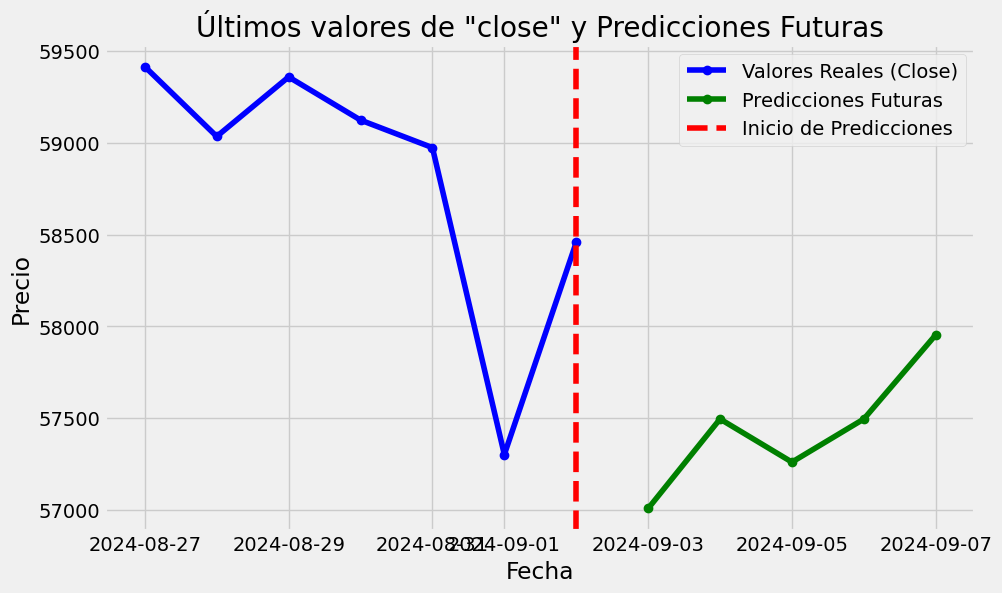

In [120]:
plt.figure(figsize=(10, 6))
plt.plot(ultimos_valores_close.index, ultimos_valores_close.values, label='Valores Reales (Close)', marker='o', color='blue')
plt.plot(pred_ultimo_valor.index, pred_ultimo_valor.values, label='Predicciones Futuras', marker='o', color='green')

plt.axvline(x=ultimos_valores_close.index[-1], color='red', linestyle='--', label='Inicio de Predicciones')
plt.title('Últimos valores de "close" y Predicciones Futuras')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.show()

In [122]:
import plotly.graph_objects as go

# Crear la figura
fig = go.Figure()

# Agregar los valores reales (últimos 10 valores)
fig.add_trace(go.Scatter(x=data.index[-10:], y=data.close.values[-10:], 
                         mode='lines+markers', 
                         name='Valores Reales', 
                         marker=dict(color='blue', symbol='cross')))

# Agregar las predicciones sobre los últimos valores y las predicciones futuras
fig.add_trace(go.Scatter(x=pred_ultimo_valor.index, y=pred_ultimo_valor.values, 
                         mode='lines+markers', 
                         name='Valores Reales y Predicciones en Últimos 5 Pasos', 
                         marker=dict(color='green')))

# Línea vertical para el inicio de predicciones futuras
fig.add_trace(go.Scatter(x=[ultimos_valores_close.index[-1], ultimos_valores_close.index[-1]], 
                         y=[min(pred_ultimo_valor.values), max(pred_ultimo_valor.values)],
                         mode='lines', 
                         name='Inicio de Predicciones Futuras', 
                         line=dict(color='red', dash='dash')))

# Personalizar el gráfico
fig.update_layout(
    title='Predicciones sobre Últimos 5 Valores y Futuras',
    xaxis_title='Fecha',
    yaxis_title='Precio',
    legend=dict(x=0, y=1.1),
    margin=dict(l=40, r=40, t=40, b=40),
    hovermode='x',
    template='plotly_white'
)

# Mostrar el gráfico
fig.show()